## Prophet Water Level Outliers

Use water level measurements of groundwater available from IntellusNM.com to identify outliers, trend, seasonality, and upset events.

This notebook contains basic statistical analysis and visualization of the data.

### Data Sources
- summary : Processed file from notebook 1-Data_Prep

### Changes
- 02-19-2024 : Started project

In [1]:
import pandas as pd
from pathlib import Path
from datetime import datetime
import seaborn as sns
import prophet
import plotly
import matplotlib.pyplot as plt
import numpy as np

/var/folders/cw/0j2ns2q56n7_rxycqh03plxm0000gn/T/ipykernel_3909/211503038.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/paulmark/JupyterNotebooks/Water Level Outliers/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot_plotly, plot_components_plotly
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


In [3]:
%matplotlib inline

### File Locations

In [6]:
today = datetime.today()
in_file = Path.cwd() / "data" / "processed" / "summary_Feb-19-2024.pkl"
report_dir = Path.cwd() / "reports"
report_file = report_dir / "Excel_Analysis_{today:%b-%d-%Y}.xlsx"

In [7]:
df = pd.read_pickle(in_file)
df = df.rename(columns={'Measurement Date Time':'ds', 'Groundwater Elevation':'y'})
df.dtypes

Site ID                                             object
Location ID                                         object
ds                                          datetime64[ns]
Groundwater Measurement                            float64
y                                                  float64
Groundwater Level Comments                          object
Groundwater Level Data Quality Code                 object
Groundwater Level Validation Reason Code            object
dtype: object

In [8]:
pip show prophet

Name: prophet
Version: 1.1.5
Summary: Automatic Forecasting Procedure
Home-page: 
Author: 
Author-email: "Sean J. Taylor" <sjtz@pm.me>, Ben Letham <bletham@fb.com>
License: MIT
Location: /Users/paulmark/JupyterNotebooks/Water Level Outliers/.venv/lib/python3.11/site-packages
Requires: cmdstanpy, holidays, importlib-resources, matplotlib, numpy, pandas, tqdm
Required-by: 
Note: you may need to restart the kernel to use updated packages.


### Perform Data Analysis - Loop through locations to identify anomalies

In [9]:
location = df[['Location ID','Site ID']].drop_duplicates().reset_index()

In [10]:
markers = {'N':'X', 'Y':'o'}
hue_order = ['N','Y']
style_order = ['N','Y']
iw = 0.9999


for location, site_id in zip(location['Location ID'], location['Site ID']):
	# Add seasonality and instantiate a new Prophet model
	model = Prophet(interval_width=iw, yearly_seasonality=True, weekly_seasonality=True)

	# print(location, parameter)
	export_subset = df[(df['Location ID'] == location) & (df['Site ID'] == site_id)]
	
	export_subset = export_subset[export_subset.groupby(['Location ID']).transform('size')>10]

	if export_subset.empty:
		continue

	# Fit the model on the training dataset
	model.fit(export_subset)

	# Make prediction
	forecast = model.predict(export_subset)

	# Merge actual and predicted values
	performance = pd.merge(export_subset, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

	# Create an anomaly indicator
	performance['anomaly'] = performance.apply(lambda rows: 1 if ((rows.y<rows.yhat_lower)|(rows.y>rows.yhat_upper)) else 0, axis = 1)

	anomalies = performance[performance['anomaly']==1].sort_values(by='ds')
	if anomalies.empty:
		continue
	
	anomalies.to_csv('anomalies.csv', mode='a', index=False, header=False)

12:32:58 - cmdstanpy - INFO - Chain [1] start processing
12:33:00 - cmdstanpy - INFO - Chain [1] done processing
12:33:00 - cmdstanpy - INFO - Chain [1] start processing
12:33:00 - cmdstanpy - INFO - Chain [1] done processing
12:33:01 - cmdstanpy - INFO - Chain [1] start processing
12:33:01 - cmdstanpy - INFO - Chain [1] done processing
12:33:03 - cmdstanpy - INFO - Chain [1] start processing
12:33:23 - cmdstanpy - INFO - Chain [1] done processing
12:33:28 - cmdstanpy - INFO - Chain [1] start processing
12:33:35 - cmdstanpy - INFO - Chain [1] done processing
12:33:39 - cmdstanpy - INFO - Chain [1] start processing
12:33:41 - cmdstanpy - INFO - Chain [1] done processing
12:33:43 - cmdstanpy - INFO - Chain [1] start processing
12:33:52 - cmdstanpy - INFO - Chain [1] done processing
12:33:54 - cmdstanpy - INFO - Chain [1] start processing
12:34:01 - cmdstanpy - INFO - Chain [1] done processing
12:34:03 - cmdstanpy - INFO - Chain [1] start processing
12:34:04 - cmdstanpy - INFO - Chain [1]

### Upload anomalies and prepare for graphing of results with anomalies identified

In [15]:
outlier_location_parameter = pd.read_csv('anomalies.csv', header=None, names = ('site_id','location_id','sample_date_time','groundwater_measurement','groundwater_elevation','groundwater_level_comment','groundwater_level_data_quality_code','groundwater_level_data_quality_reason_code','yhat','yhat_lower','yhat_upper','anomaly'))
outlier_location_parameter['sample_date_time'] = pd.to_datetime(outlier_location_parameter['sample_date_time'])
outlier_location_parameter = outlier_location_parameter[outlier_location_parameter['sample_date_time']>pd.to_datetime('2018-05-01')]
outlier_location_parameter = outlier_location_parameter[['location_id','site_id','sample_date_time']].drop_duplicates()
# outlier_location_parameter.to_csv('recent_anomalies.csv', index=False, header=False)
outlier_location = outlier_location_parameter[['location_id']].drop_duplicates()
outlier_location.dtypes

location_id    object
dtype: object

In [17]:
for location in outlier_location['location_id']:
	print(location)

CrIN-2
CrIN-3
CrIN-4
CrIN-5
R-11
R-13
R-15
R-35a
R-35b
R-42
R-62
SIMR-2


12:44:45 - cmdstanpy - INFO - Chain [1] start processing
12:44:51 - cmdstanpy - INFO - Chain [1] done processing
/Users/paulmark/JupyterNotebooks/Water Level Outliers/.venv/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/paulmark/JupyterNotebooks/Water Level Outliers/.venv/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
12:44:56 - cmdstanpy - INFO - Chain [1] start processing
12:44:58 - cmdstanpy 

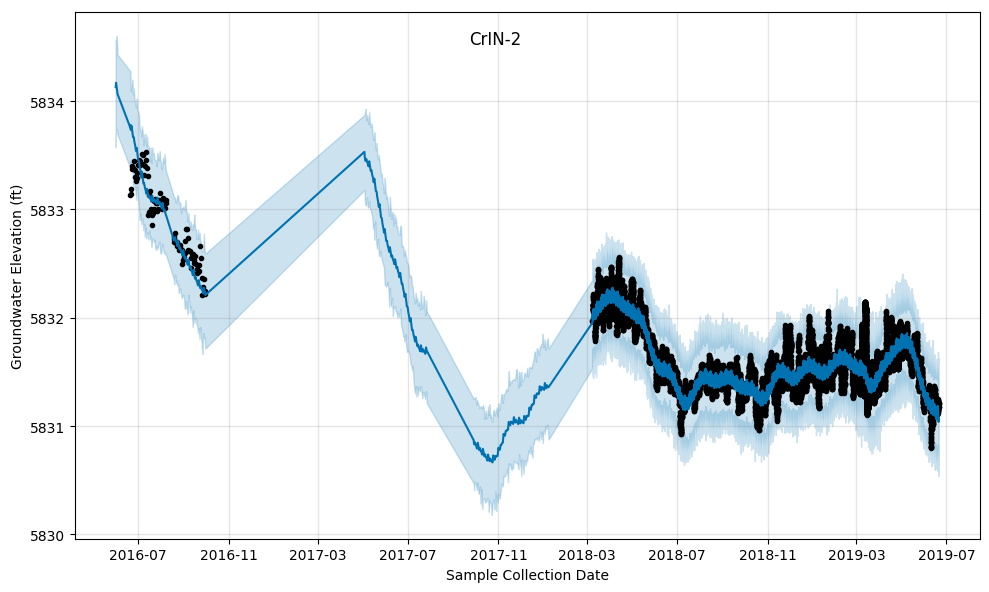

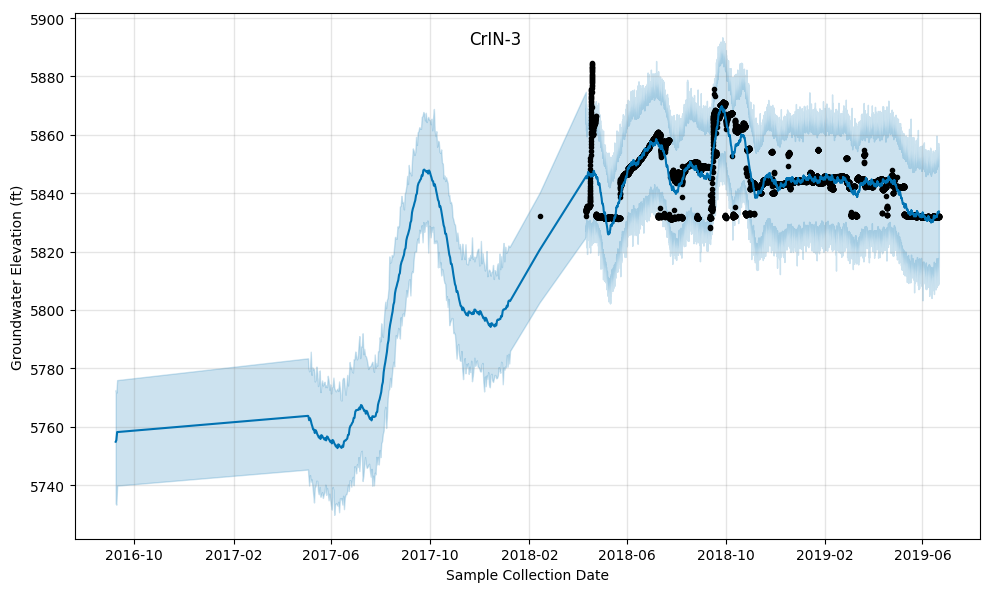

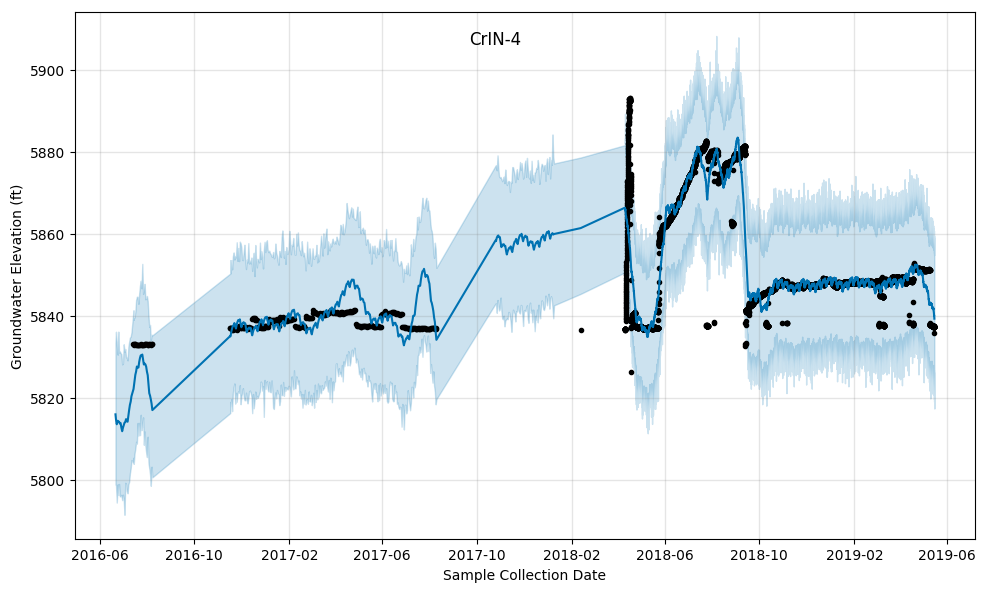

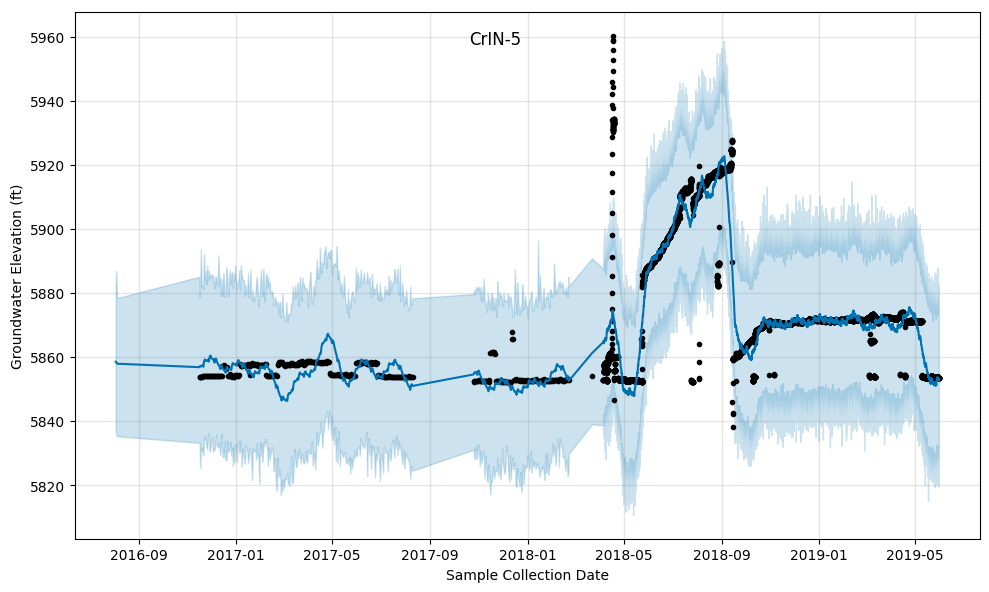

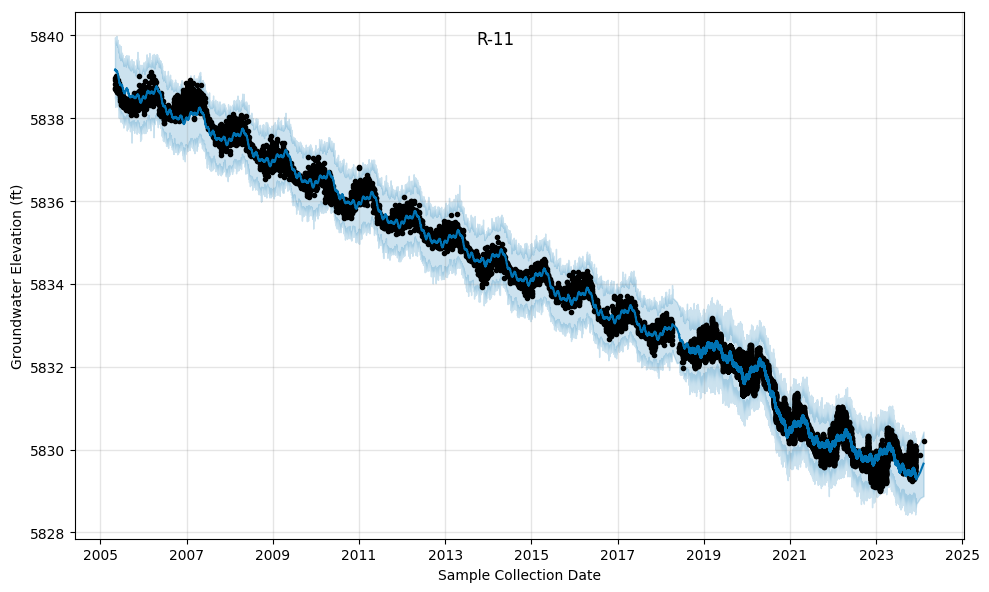

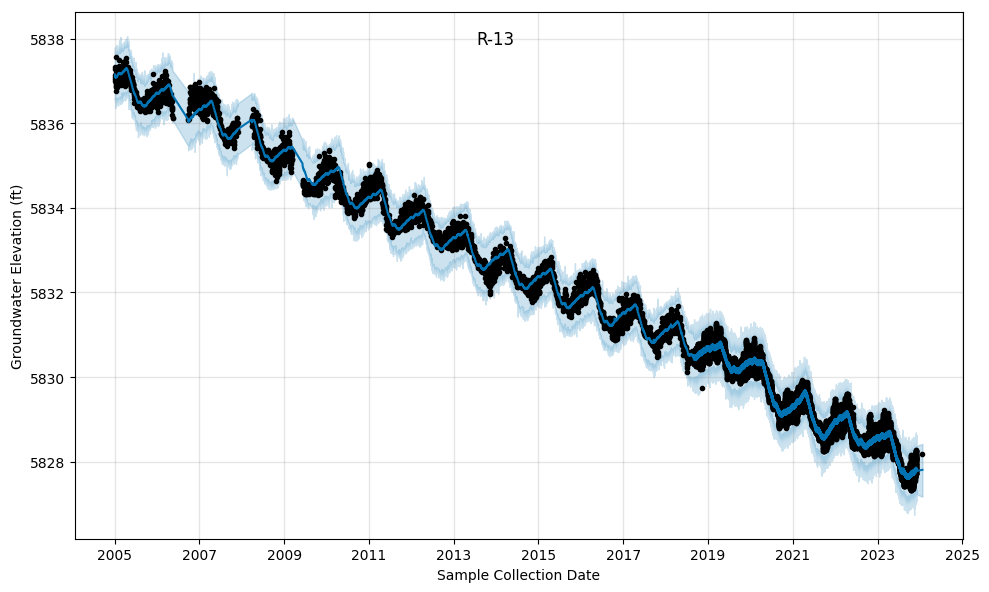

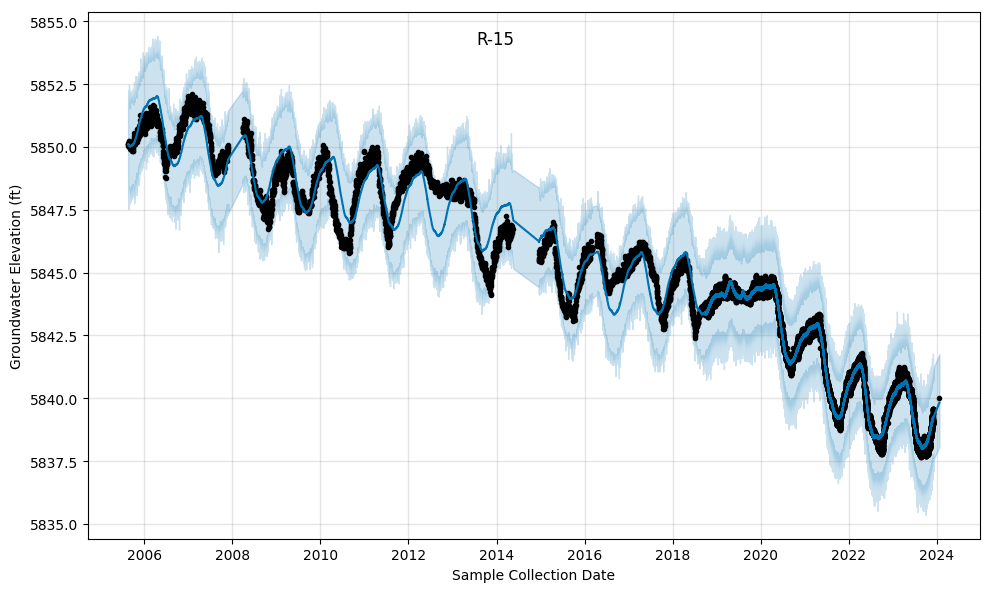

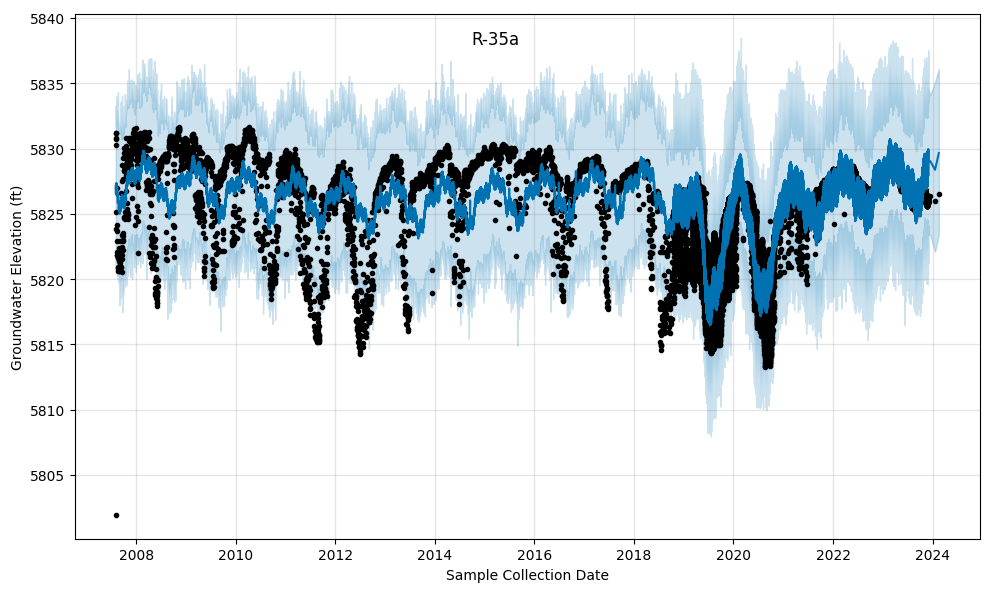

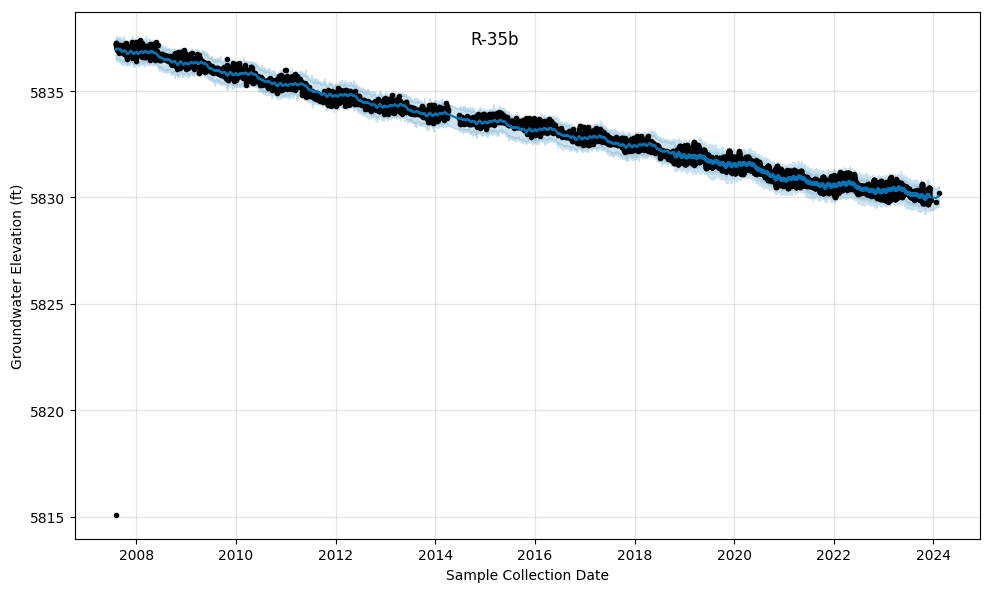

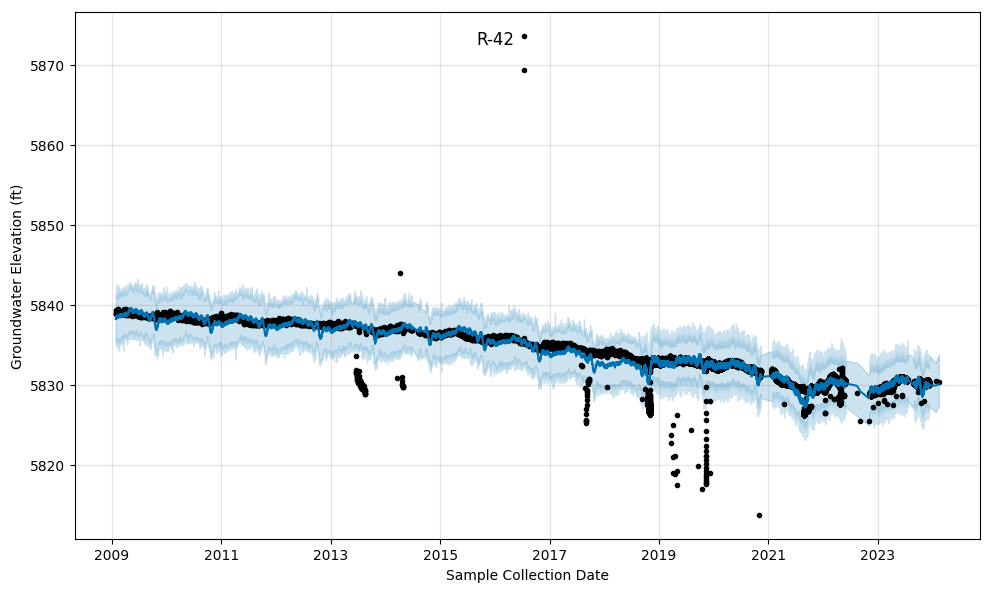

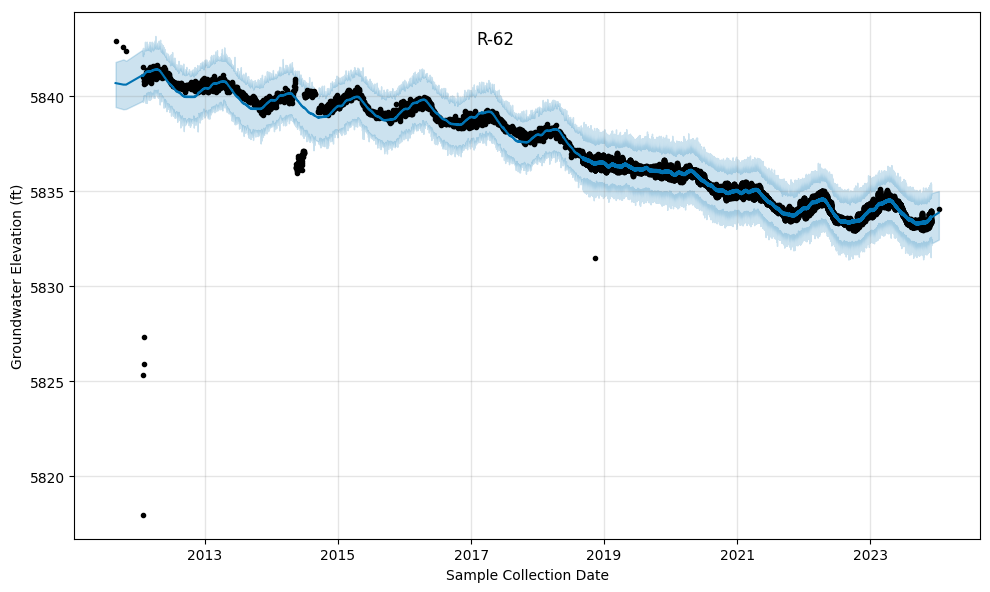

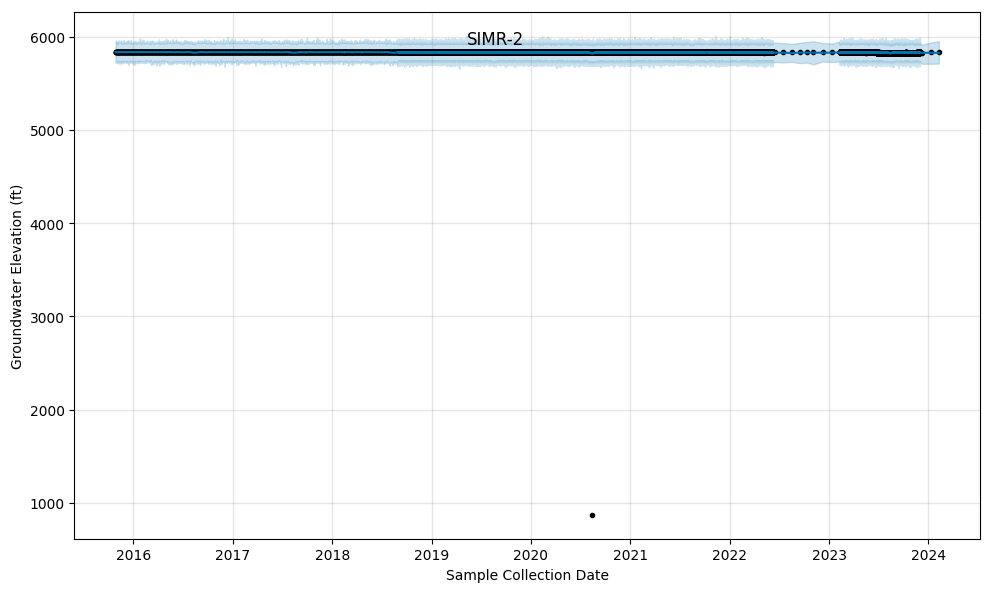

In [18]:
markers = {'N':'X', 'Y':'o'}
hue_order = ['N','Y']
style_order = ['N','Y']


for location in outlier_location['location_id']:
	# Add seasonality and instantiate a new Prophet model
	model = Prophet()
	model = Prophet(interval_width=iw, yearly_seasonality=True, weekly_seasonality=True)

	# print(location, parameter)

	export_subset = df[(df['Location ID'] == location)]

	if export_subset.empty:
		continue

	# Fit the model on the training dataset
	model.fit(export_subset)

	# Make prediction
	forecast = model.predict(export_subset)

	# Merge actual and predicted values
	performance = pd.merge(export_subset, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

	# Create an anomaly indicator
	performance['anomaly'] = performance.apply(lambda rows: 1 if ((rows.y<rows.yhat_lower)|(rows.y>rows.yhat_upper)) else 0, axis = 1)

	anomalies = performance[performance['anomaly']==1].sort_values(by='ds')
	# if anomalies.empty:
	# 	continue
	
	# Visualize the anomalies
	fig = model.plot(forecast); 
	
	# a = add_changepoints_to_plot(fig.gca(), model, forecast)# Add semi-colon to remove the duplicated chart

	# py.iplot(fig)

	name = (location +' ' + ' outliers.png').replace("/","-")
	y_axis_label ='Groundwater Elevation (ft)'
	plt.ylabel(y_axis_label)
	plt.xlabel('Sample Collection Date')
	plt.suptitle('\n'+location)
	fig.savefig('reports/' + name)